# Pre-processing and Modelling

Notebook 3 of 4

## WordCloud
We will explore most common two-word phrases under 'title' - using Word Cloud

In [10]:
import sys
print(sys.executable)

C:\Users\yuner\anaconda3\python.exe


In [2]:
!C:/Users/yuner/anaconda3/python -m pip install wordcloud

In [18]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

In [4]:
# import dataset
combined_df = pd.read_csv("./datasets/combined_cleaned_reddit_selftext.csv")

In [5]:
combined_df.head()

,subreddit,title_selftext,created_utc,stemmed_title_selftext
0,1,my coworker placing the hash browns like army ...,1663204910,cowork place hash brown like armi troopsface_w...
1,1,whats the deal with these? nan,1663196066,what deal
2,1,working for dunkin i know i asked about this b...,1663193081,work know i ask i curiou experi work dunkin wo...
3,1,how to make the ice tea ordered from door dash...,1663190691,make ice tea order door dash tast the ice tea ...
4,1,we still got 4 more hours of shift and this is...,1663185603,still got 4 hour shift we gotexploding_head


In [6]:
dunkin_posts = list(combined_df[combined_df['subreddit'] == 1]['title_selftext'])

In [7]:
sbux_posts = list(combined_df[combined_df['subreddit'] == 0]['title_selftext'])

Text(0.5, 1.0, 'r/DunkinDonuts')

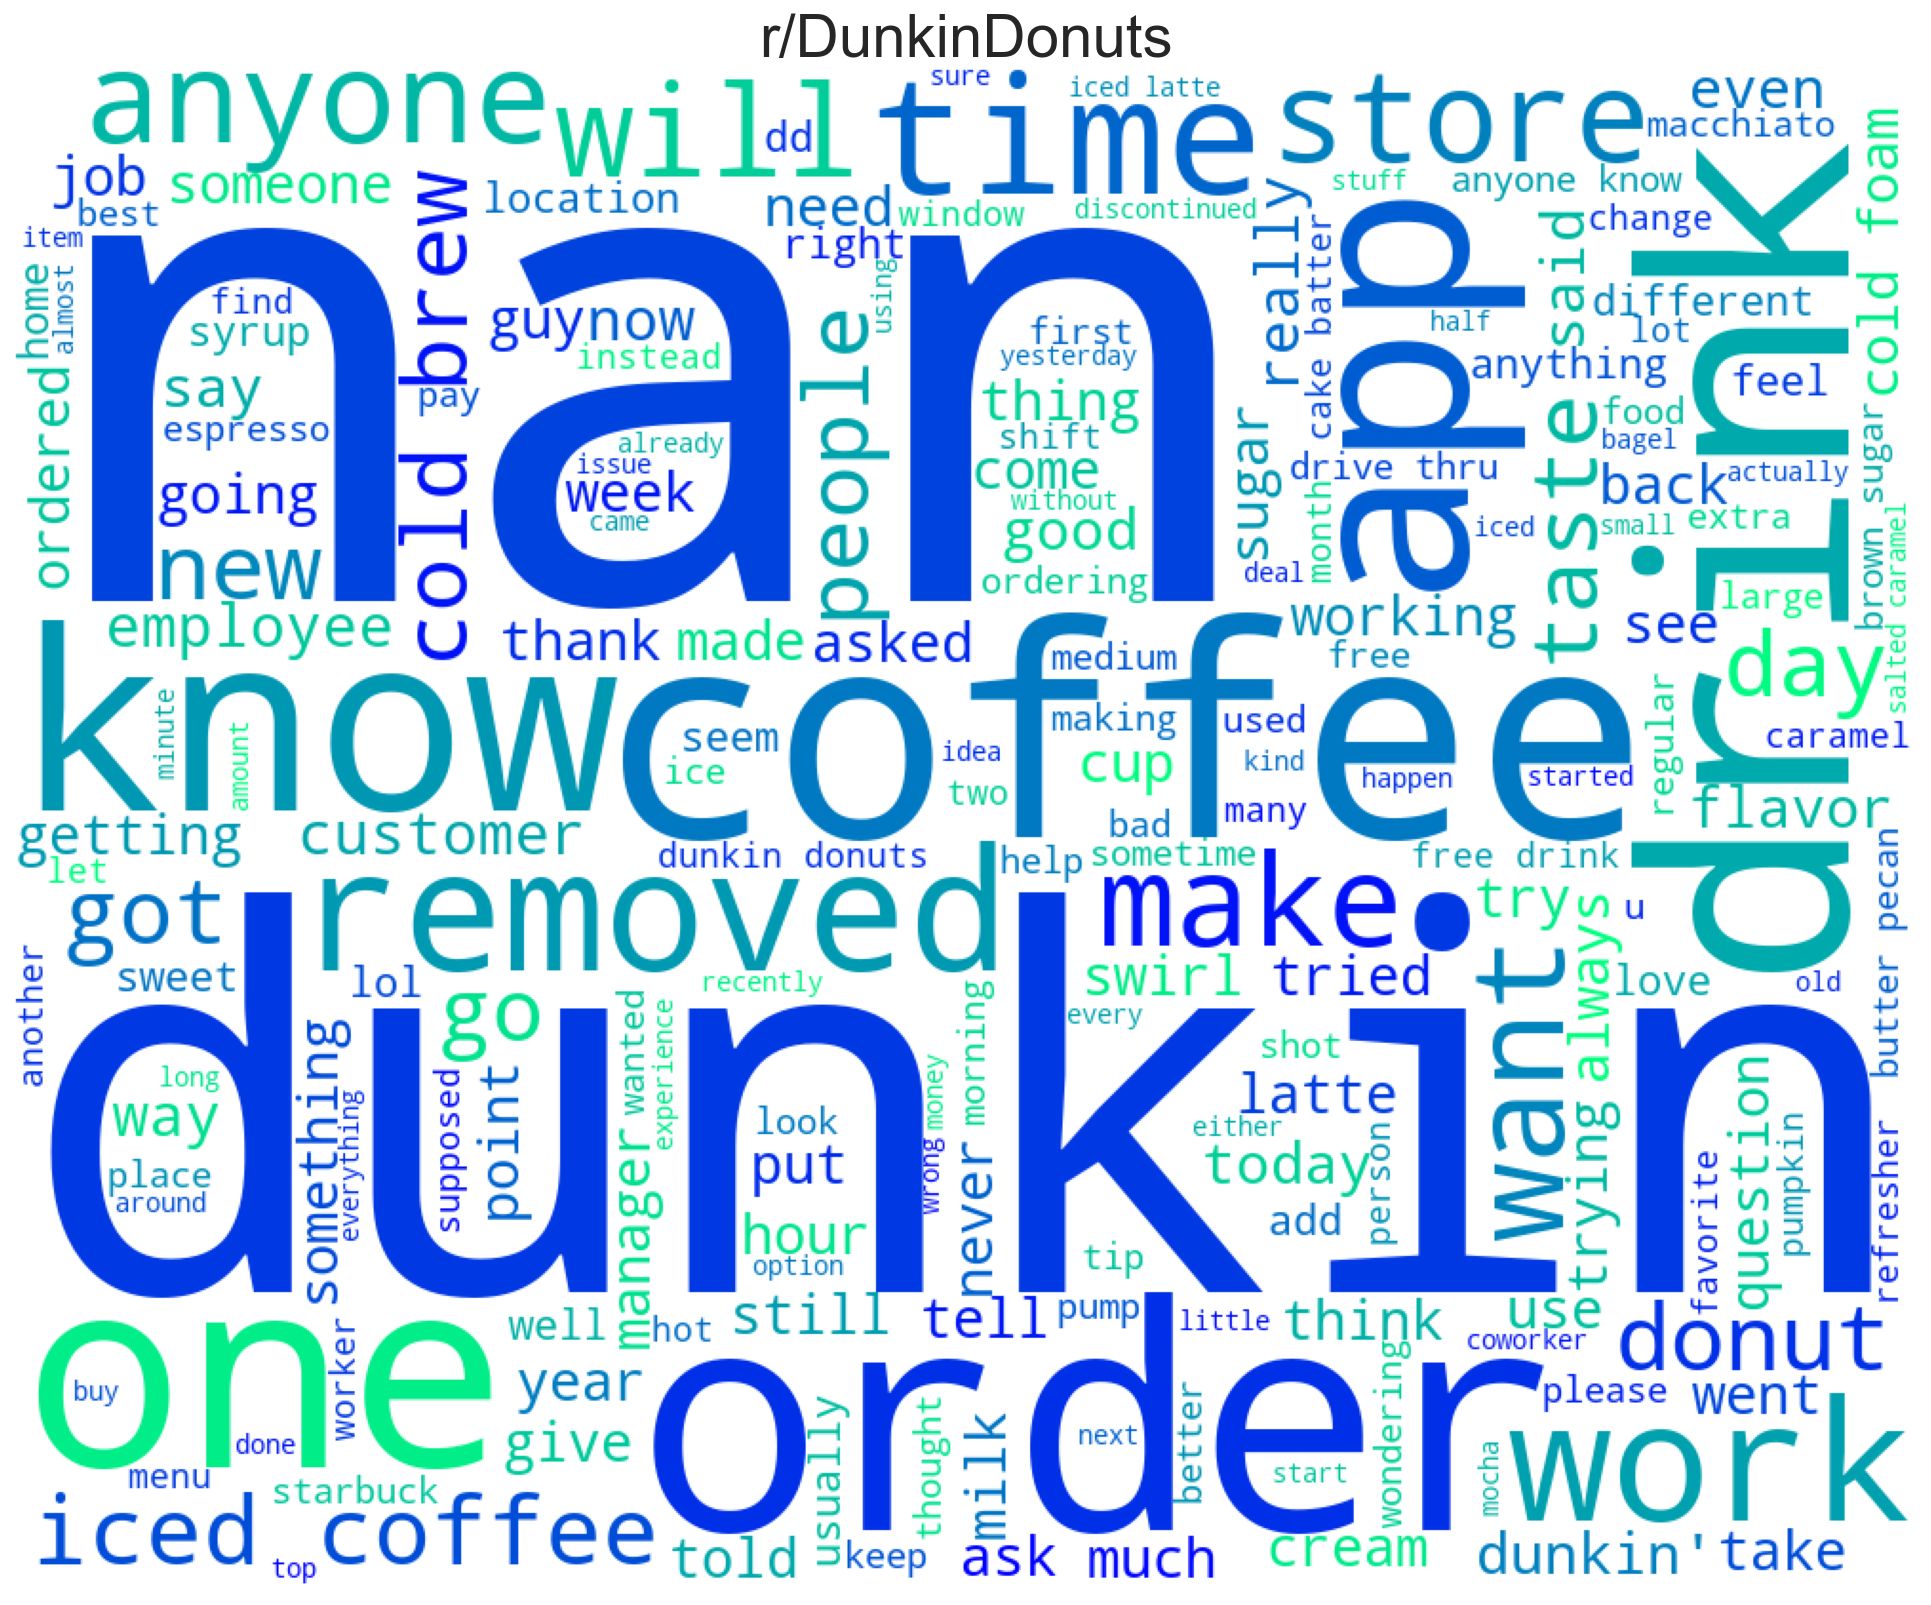

In [8]:
# # Alterative way to plot
# def plot_cloud(wordcloud):
#     plt.figure(figsize=(20, 14))
#     plt.imshow(wordcloud)
#     plt.axis("off");

# wc_dunkin = WordCloud(width=1000, height=800, background_color='white', colormap='winter').generate(' '.join(dunkin_posts))
# plot_cloud(wc_dunkin)
# plt.title('r/DunkinDonuts',fontsize=30)

In [9]:
cvec = CountVectorizer(stop_words = 'english', ngram_range=(2,2))
combined_cvec = pd.DataFrame(cvec.fit_transform(combined_df['title_selftext']).todense(),
                                              columns = cvec.get_feature_names_out())
dunkin_top = combined_cvec.sum().sort_values(ascending = False).head(100)
sbux_top = combined_cvec.sum().sort_values(ascending = False).head(100)

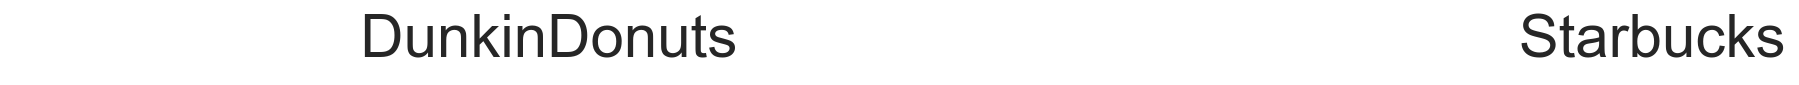

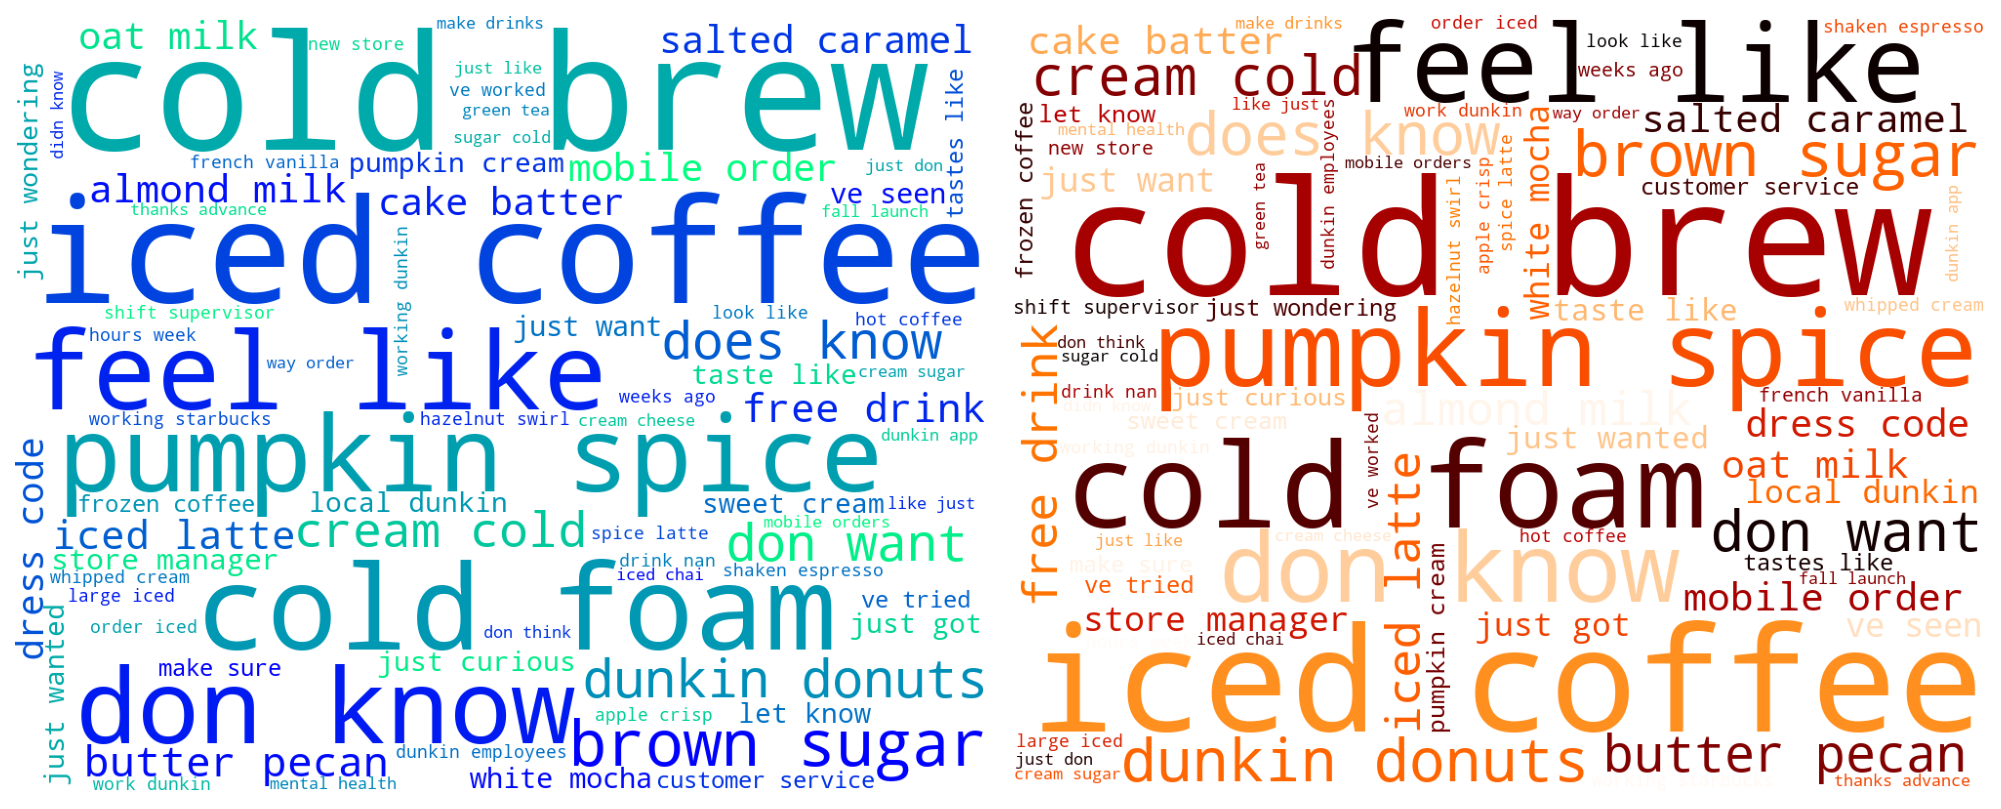

In [12]:
# set up WordCloud
wc_dunkin = WordCloud(max_words=75, width=1000, height=800, background_color='white',
                       colormap='winter').generate_from_frequencies(dunkin_top) 

wc_sbux = WordCloud(max_words=75, width=1000, height=800, background_color ='white',
                      colormap='gist_heat').generate_from_frequencies(sbux_top) 

plt.figure(figsize=(8,0.3))
plt.text(x=0.35,                              
         y=0.9,                             
         s='  DunkinDonuts                                               Starbucks', 
         ha='left',                        
         va='center',                       
         size=30)                         
plt.axis('off')

# plot the WordCloud image 
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax[0].imshow(wc_dunkin)
ax[0].axis('off')
ax[1].imshow(wc_sbux)
ax[1].axis('off')
plt.tight_layout()

From the above word cloud images, we are keen to understand why some two-word phrases appear more commonly than others, on Dunkin' and Starbucks' subreddit.

In [13]:
# check if there's any null value
combined_df[combined_df['stemmed_title_selftext']=='']

,subreddit,title_selftext,created_utc,stemmed_title_selftext


In [14]:
# rename the target variable
combined_df.rename({'subreddit':'is_dunkin'}, inplace=True, axis=1)

In [15]:
combined_df.head(3)

,is_dunkin,title_selftext,created_utc,stemmed_title_selftext
0,1,my coworker placing the hash browns like army ...,1663204910,cowork place hash brown like armi troopsface_w...
1,1,whats the deal with these? nan,1663196066,what deal
2,1,working for dunkin i know i asked about this b...,1663193081,work know i ask i curiou experi work dunkin wo...


## Train-Test-Split
Holdout 30% of sample data not to be exposed to any fitting from the modeling. Then we generate predictions against this holdout data.

In [16]:
X = combined_df['stemmed_title_selftext']
y = combined_df['is_dunkin']

In [19]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=42)

In [23]:
# instantiate TfidfVectorizer with updated stopwords
tvec = TfidfVectorizer(stop_words='english')

# fit the training dataset
tvec.fit(X_train)

TfidfVectorizer(stop_words='english')

In [24]:
# transform the training data
X_train = pd.DataFrame(tvec.transform(X_train).todense(),
                       columns=tvec.get_feature_names())

In [25]:
# transform the test data
X_test = pd.DataFrame(tvec.transform(X_test).todense(),
                      columns=tvec.get_feature_names())

In [26]:
# instantiate logistic regression 
lr = LogisticRegression()

# list out the parameters
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 0, 40)
}

# do a gridsearch for the best params for model 
lr_gridsearch = GridSearchCV(
            lr,
            lr_params,
            cv=5,
            verbose=1,
            n_jobs=2,
            return_train_score=False)

lr_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': array([1.00000000e-04, 1.26638017e-04, 1.60371874e-04, 2.03091762e-04,
       2.57191381e-04, 3.25702066e-04, 4.12462638e-04, 5.22334507e-04,
       6.61474064e-04, 8.37677640e-04, 1.06081836e-03, 1.34339933e-03,
       1.70125428e-03, 2.15443469e-03, 2.72833338e-03, 3.45510729e-03,
       4.37547938e-03, 5.54102033e-03...8.88623816e-03,
       1.12533558e-02, 1.42510267e-02, 1.80472177e-02, 2.28546386e-02,
       2.89426612e-02, 3.66524124e-02, 4.64158883e-02, 5.87801607e-02,
       7.44380301e-02, 9.42668455e-02, 1.19377664e-01, 1.51177507e-01,
       1.91448198e-01, 2.42446202e-01, 3.07029063e-01, 3.88815518e-01,
       4.92388263e-01, 6.23550734e-01, 7.89652287e-01, 1.00000000e+00]),
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [28]:
# view the best parameters and scores following the GridSearchCV
print('Best parameters: {}'.format(lr_gridsearch.best_params_))
print('Best score: {}'.format(lr_gridsearch.best_score_))

Best parameters: {'C': 1.0, 'penalty': 'l2'}
Best score: 0.7897810218978102


In [29]:
# generate predictions
preds = lr_gridsearch.best_estimator_.predict(X_test)

## Features Coefficient

In [30]:
# create a DataFrame containing the features and their coefficients
coefficient_df = pd.DataFrame({'feature':X_test.columns, 'coef':lr_gridsearch.best_estimator_.coef_[0]})

# sort the values by their coefficients 
coefficient_df.sort_values(by=['coef'], inplace=True, ascending=False)  

In [31]:
# view the top 10 words that indicate that the posts will be considered as 'Dunkin'
print('Top 10 words for Dunkin')
coefficient_df.head(10)

Top 10 words for Dunkin


,feature,coef
1849,dunkin,4.877422
1934,employe,3.620588
5432,swirl,3.548047
1527,dd,3.176407
1195,coffe,2.773869
2213,flavor,2.430262
1748,donut,2.345478
2308,free,2.051044
2338,frozen,2.006313
5621,toast,1.957519


In [33]:
# view the top 10 words that indicate that the posts will be considered as 'Sbux'
print('Top 10 words for Starbucks')
coefficient_df.tail(10)

Top 10 words for Starbucks


,feature,coef
2492,grand,-1.841211
1797,dress,-1.845148
5959,venti,-1.978953
4915,shift,-2.152363
5295,store,-2.172475
5044,sm,-2.269343
2303,frappuccino,-2.574679
5243,starbuck,-2.907849
3983,partner,-4.017904
635,barista,-4.913113


Text(0, 0.5, 'Words')

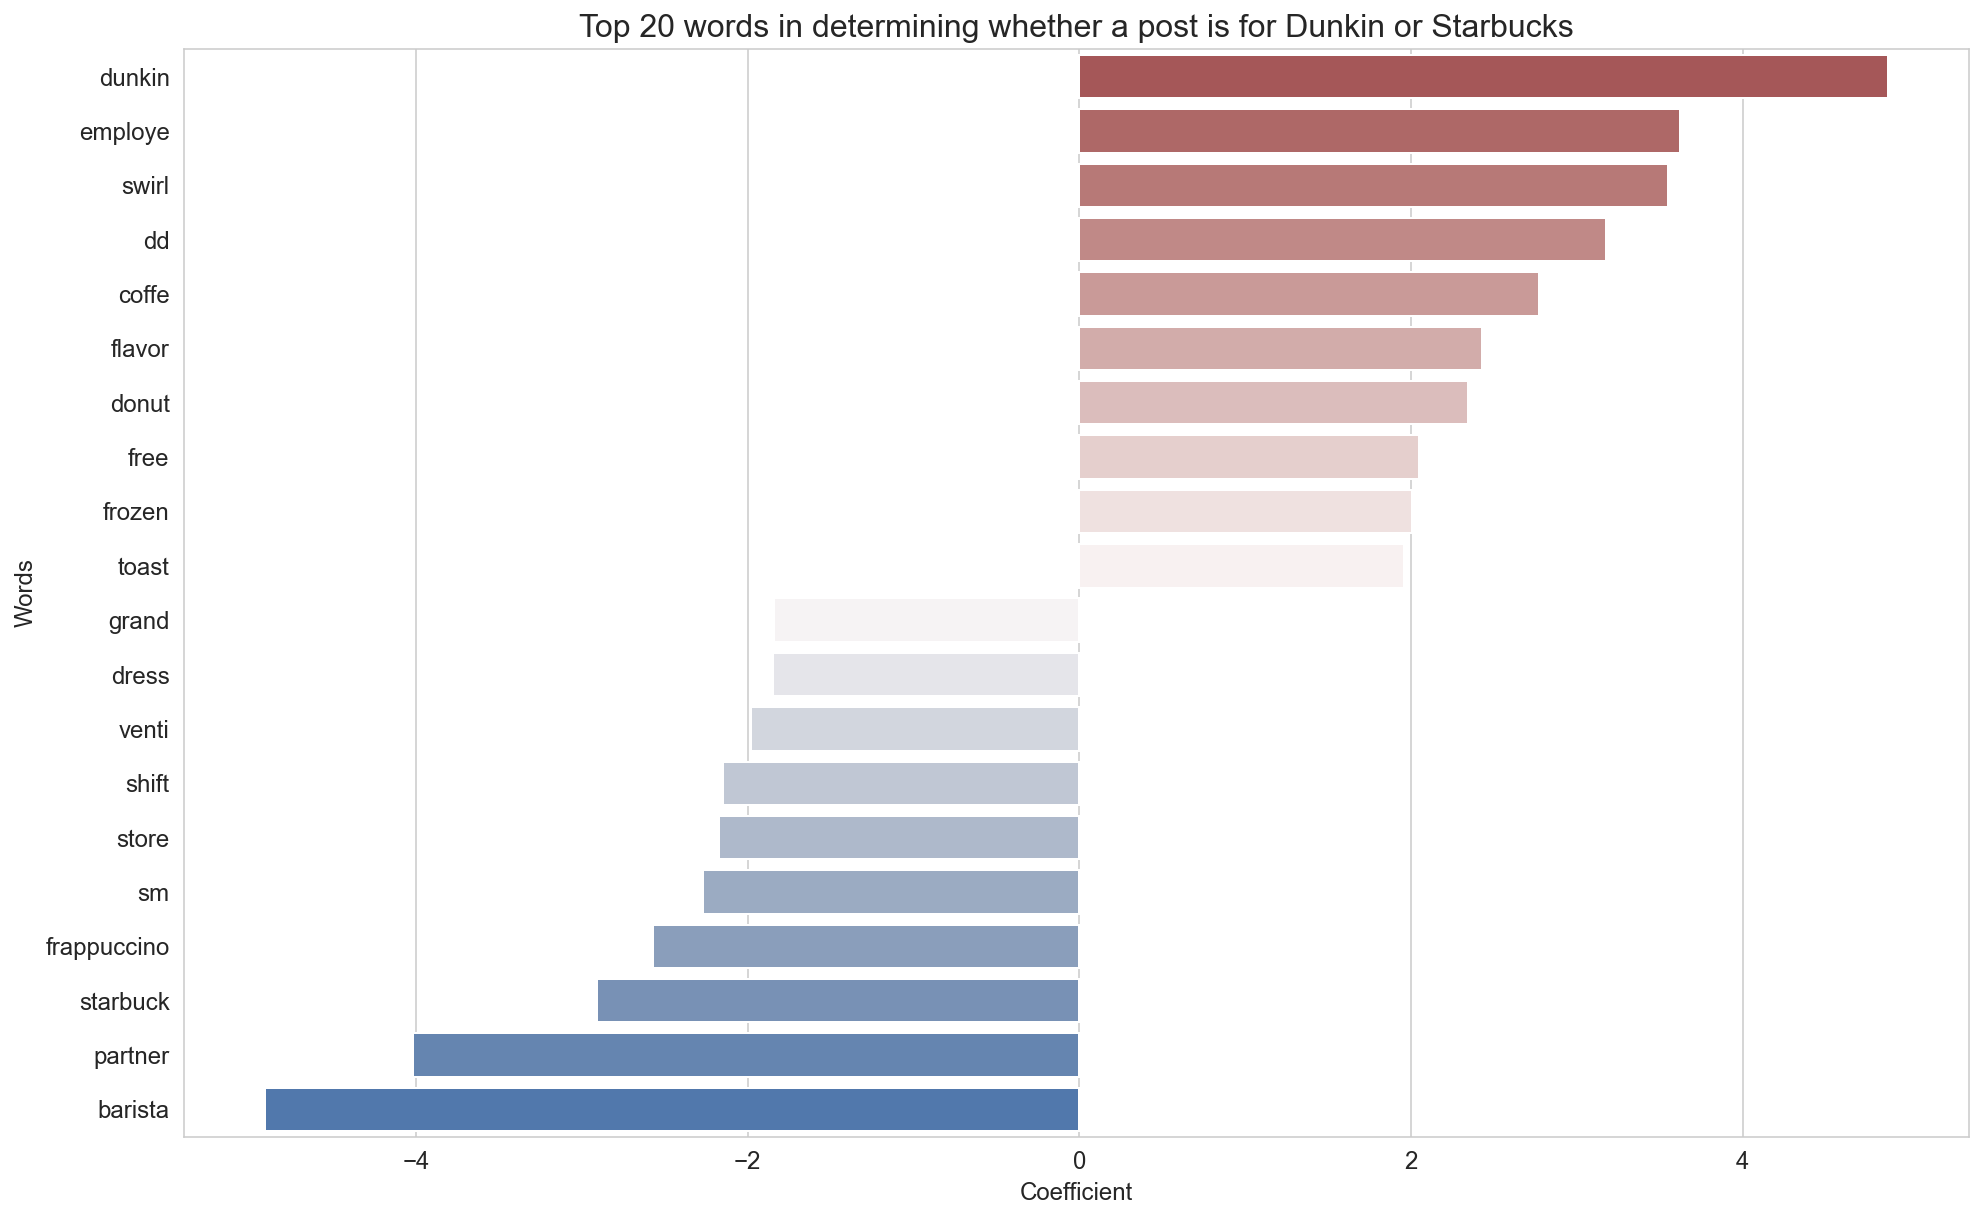

In [34]:
# visualise the top 20 words predicting that a post is in Walmart vs Costco
top_coefficient_df = pd.concat([coefficient_df.head(10), coefficient_df.tail(10)])
plt.figure(figsize=(16,10))
sns.barplot(y='feature', x='coef', data=top_coefficient_df, palette='vlag_r')
sns.set(style='whitegrid')
plt.title('Top 20 words in determining whether a post is for Dunkin or Starbucks', fontsize=16)
plt.tick_params(labelsize=12)
plt.xlabel('Coefficient', fontsize=12)
plt.ylabel('Words', fontsize=12)

Examining the top 20 words that determine whether a post is for Dunkin or Starbucks.